In [1]:
from optimus import Optimus
op = Optimus()

In [2]:
op.spark

In [3]:
op.sc

<SparkContext master=local[*] appName=optimus>

## Exploratory Data Analysis

In [73]:
df = op.load.csv("data/train.csv")

In [5]:
df.table()

Loan_ID 1 (string) nullable,Gender 2 (string) nullable,Married 3 (string) nullable,Dependents 4 (string) nullable,Education 5 (string) nullable,Self_Employed 6 (string) nullable,ApplicantIncome 7 (int) nullable,CoapplicantIncome 8 (double) nullable,LoanAmount 9 (int) nullable,Loan_Amount_Term 10 (int) nullable,Credit_History 11 (int) nullable,Property_Area 12 (string) nullable,Loan_Status 13 (string) nullable
LP001002,Male,No,0,Graduate,No,5849,0.0,None,360,1,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not⋅Graduate,No,2583,2358.0,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141,360,1,Urban,Y
LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267,360,1,Urban,Y
LP001013,Male,Yes,0,Not⋅Graduate,No,2333,1516.0,95,360,1,Urban,Y
LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158,360,0,Semiurban,N
LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168,360,1,Urban,Y
LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349,360,1,Semiurban,N


Including 'nan' as Null in processing 'Loan_ID'
Including 'nan' as Null in processing 'Gender'
Including 'nan' as Null in processing 'Married'
Including 'nan' as Null in processing 'Dependents'
Including 'nan' as Null in processing 'Education'
Including 'nan' as Null in processing 'Self_Employed'
Including 'nan' as Null in processing 'Property_Area'
Including 'nan' as Null in processing 'Loan_Status'


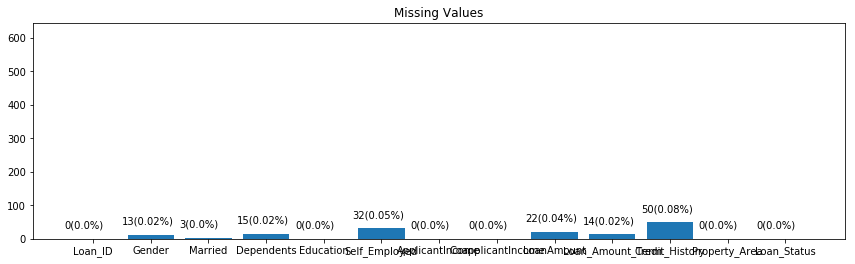

In [6]:
op.profiler.missing_values(df, "*")

Including 'nan' as Null in processing 'Loan_ID'
Including 'nan' as Null in processing 'Gender'
Including 'nan' as Null in processing 'Married'
Including 'nan' as Null in processing 'Dependents'
Including 'nan' as Null in processing 'Education'
Including 'nan' as Null in processing 'Self_Employed'
Including 'nan' as Null in processing 'Property_Area'
Including 'nan' as Null in processing 'Loan_Status'


Number of columns,13
Number of rows,614
Total Missing (%),0.24%
Total size in memory,-1 Bytes
String,7
Numeric,6
Date,0
Bool,0
Array,0
Not available,0
Unique,618

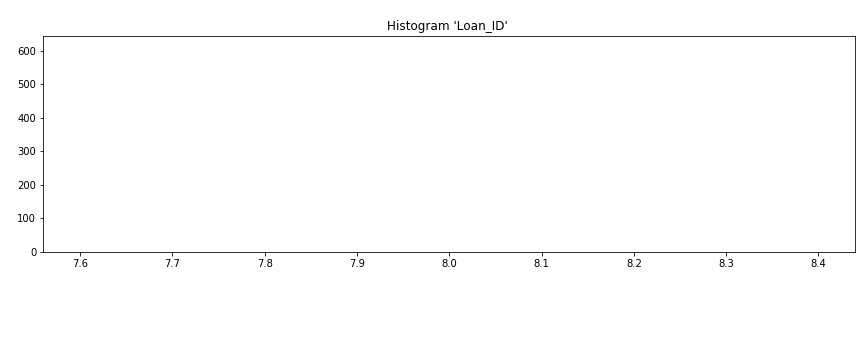
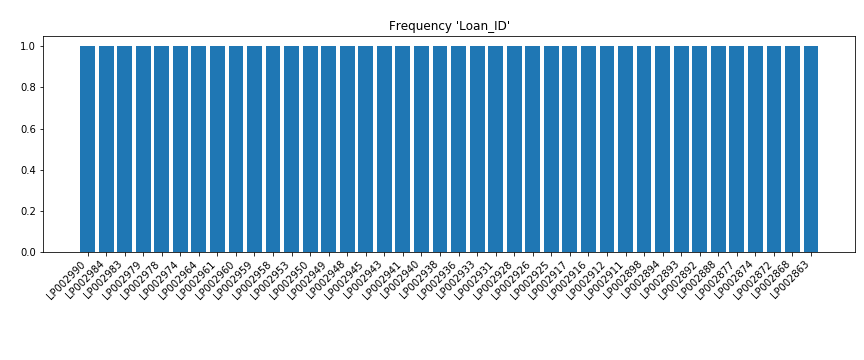
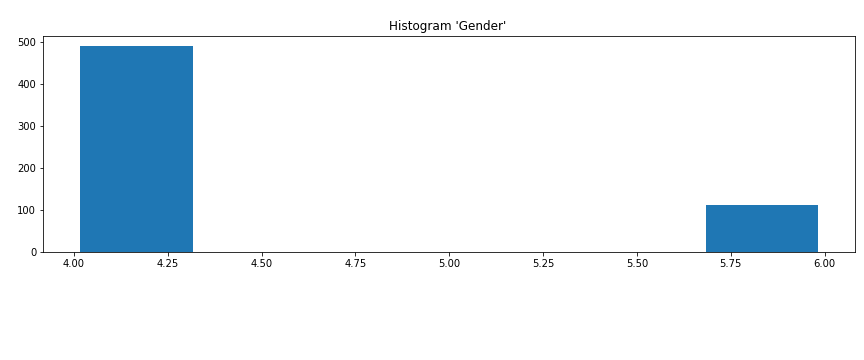
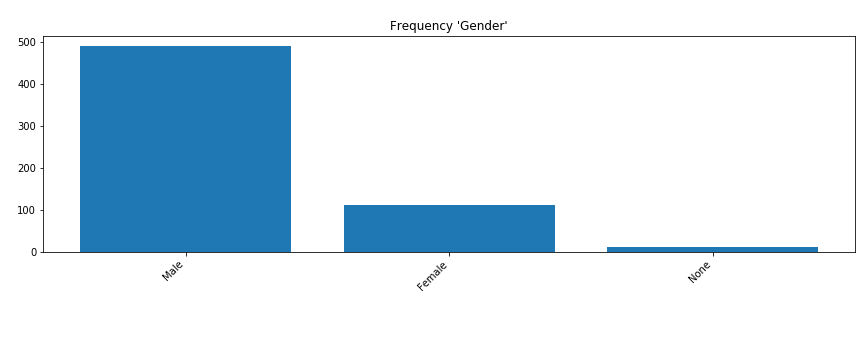
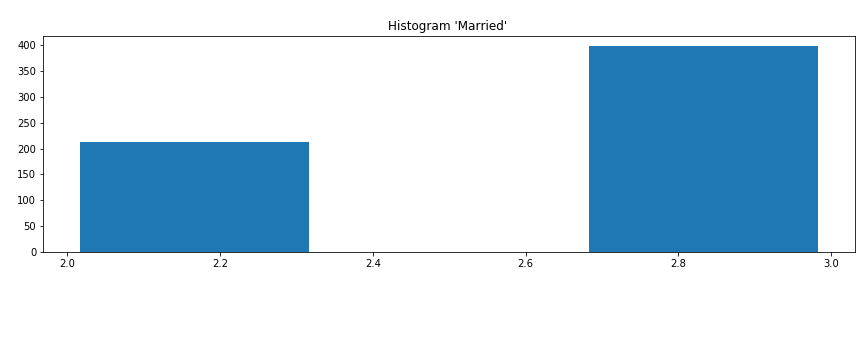
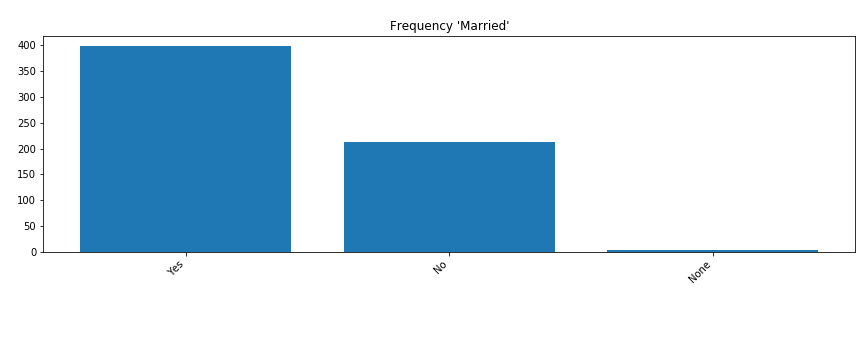
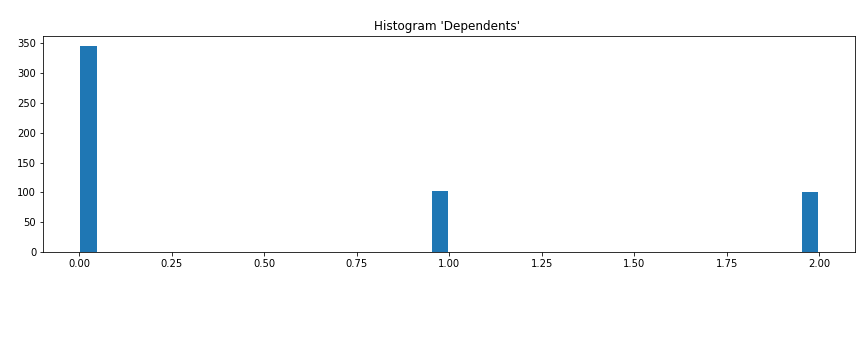
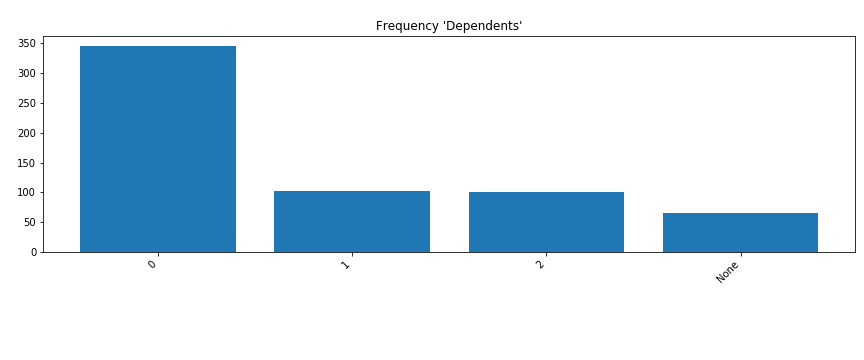
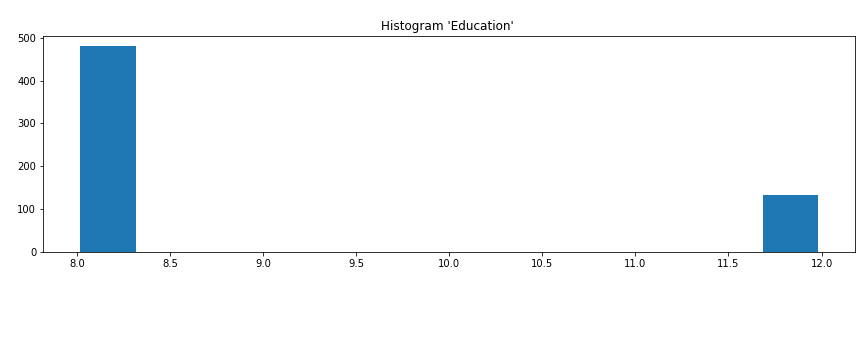
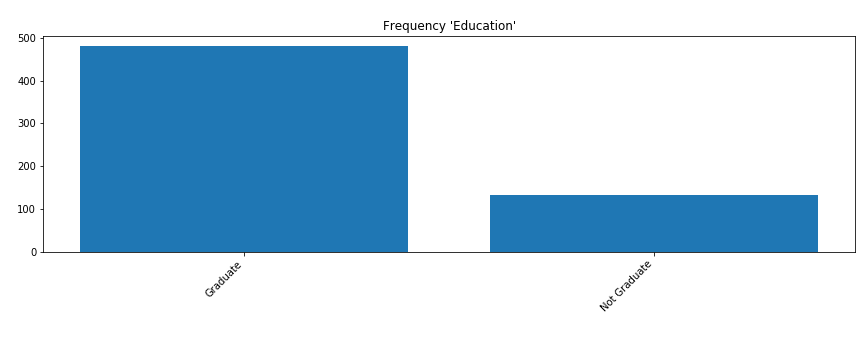
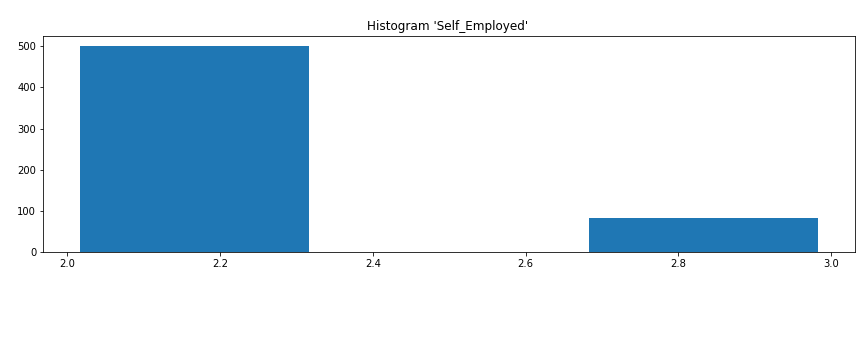
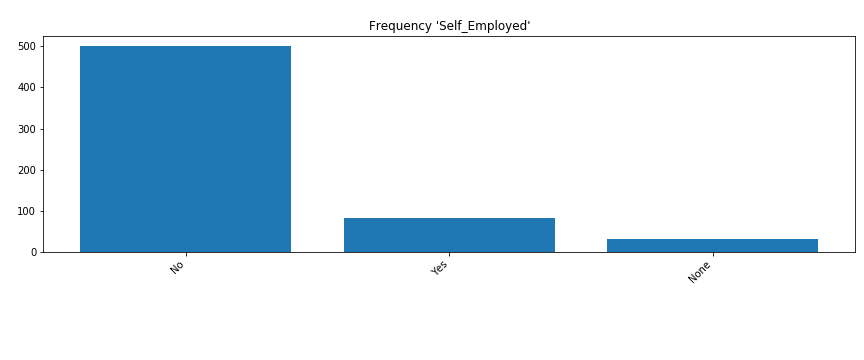
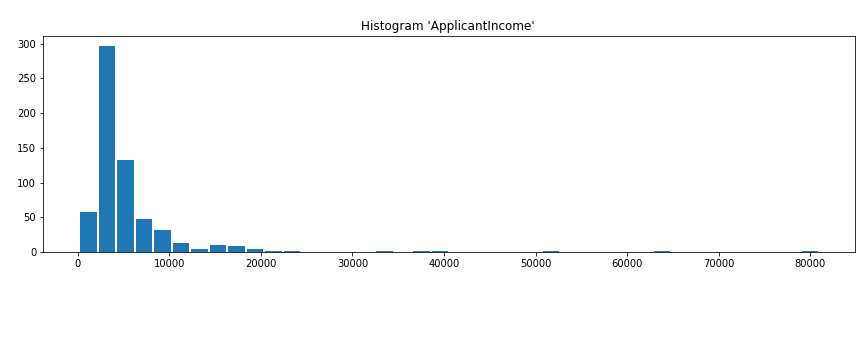
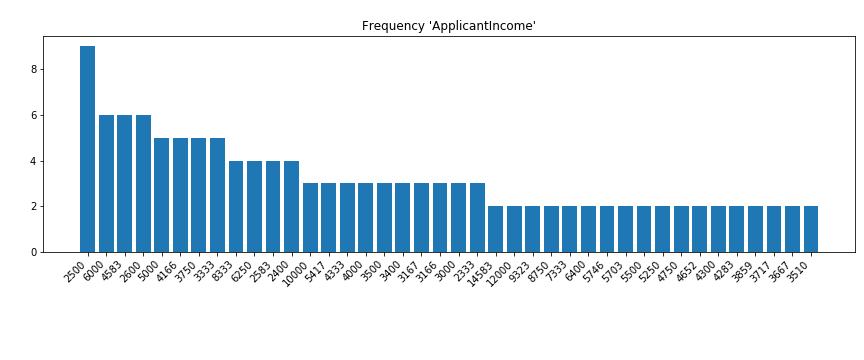
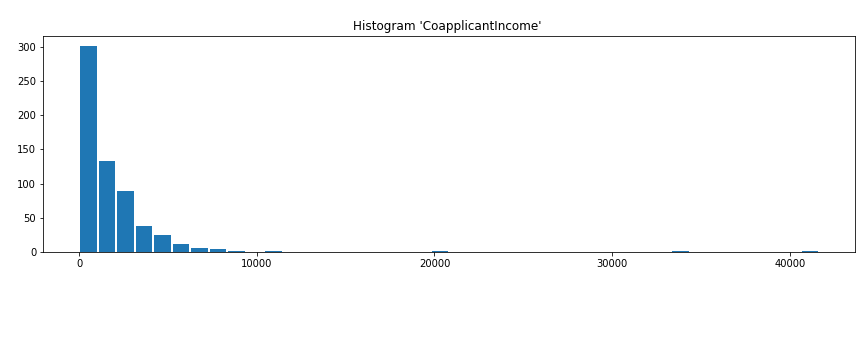
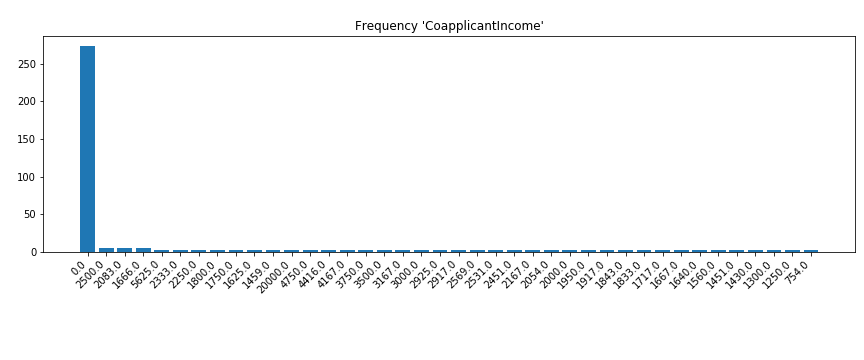
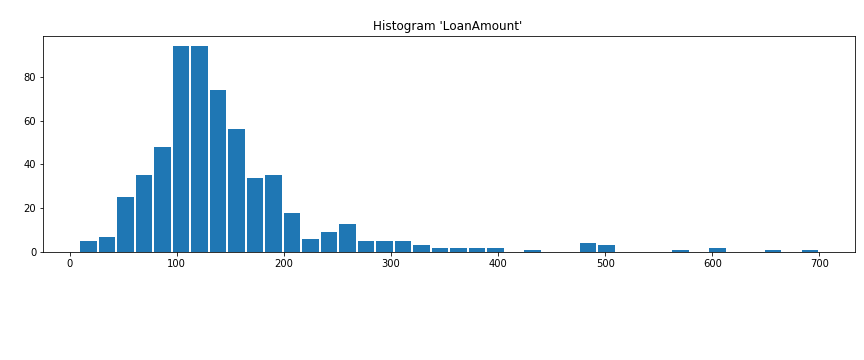
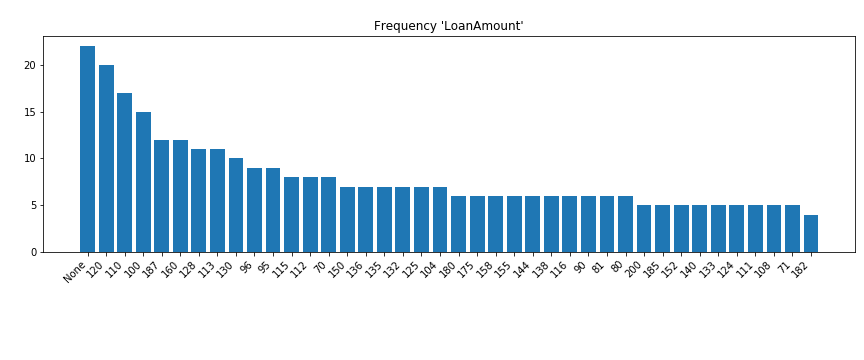
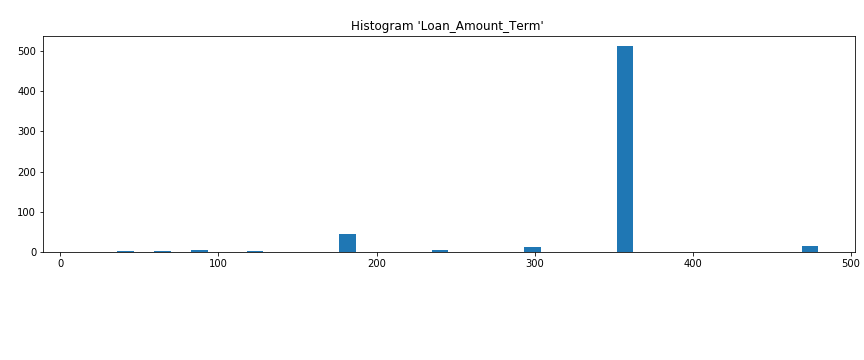
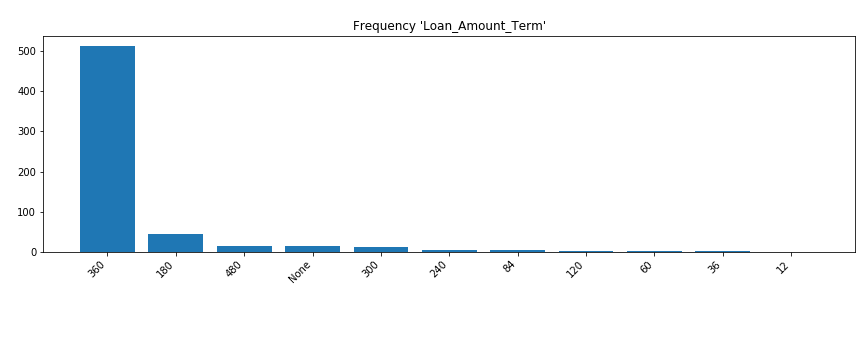
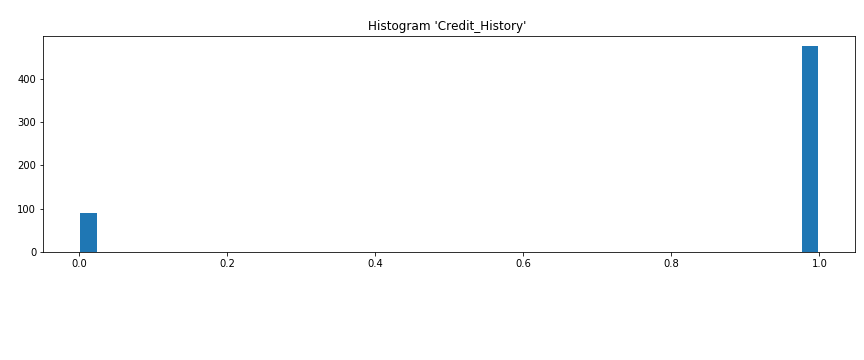
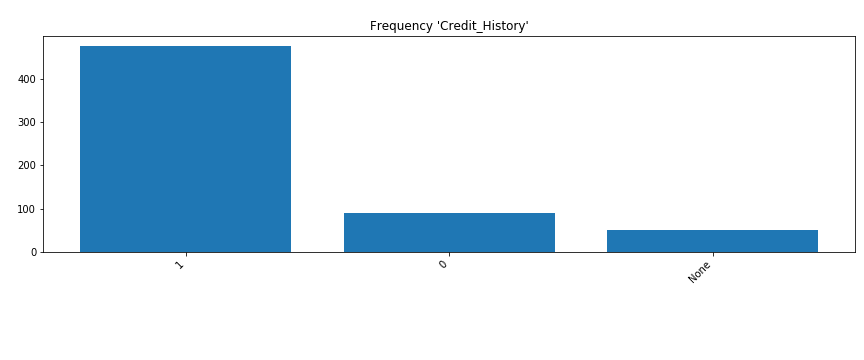
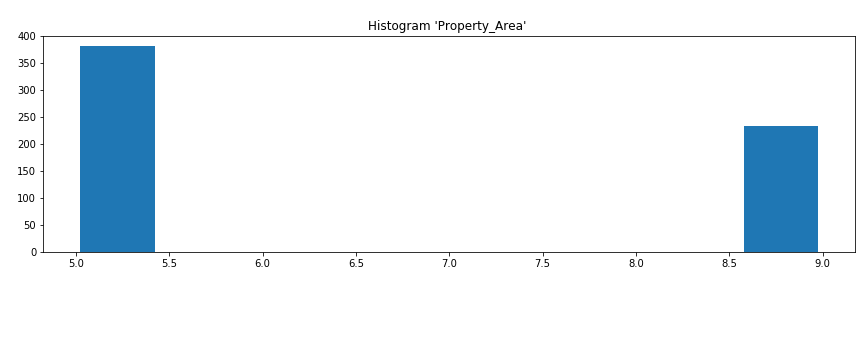
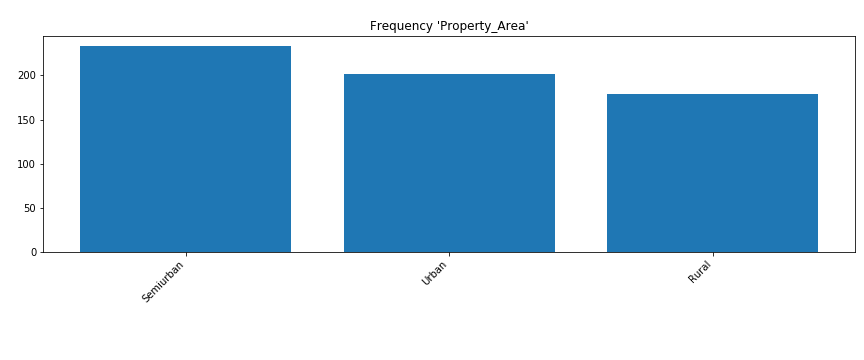
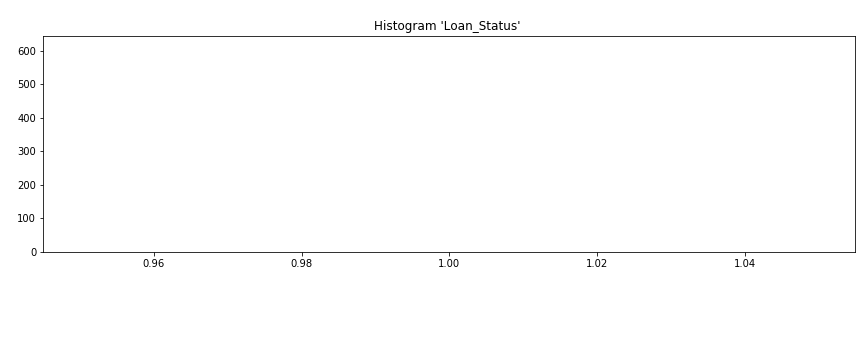
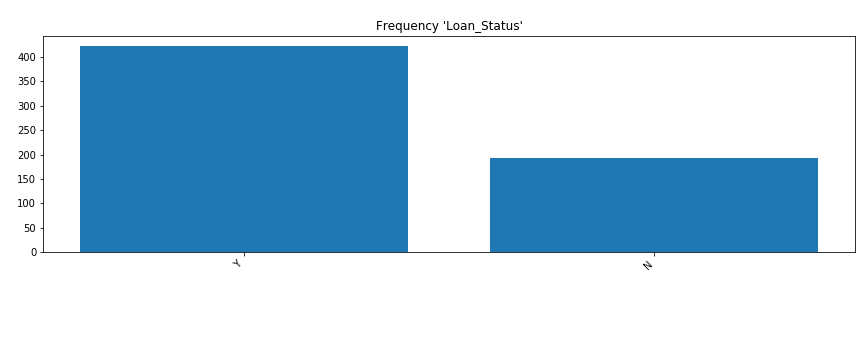

In [7]:
op.profiler.run(df, "*",infer=True)

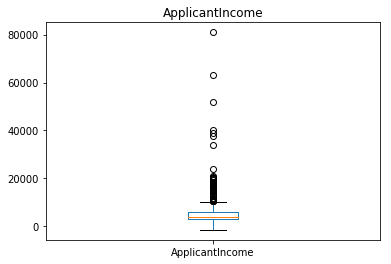

<Figure size 864x360 with 0 Axes>

In [12]:
df.plot.box("ApplicantIncome")

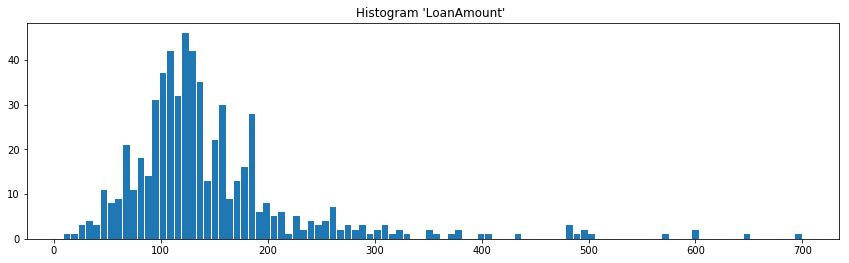

In [15]:
df.plot.hist("LoanAmount", buckets=100)

## Data cleansing

In [20]:
from pyspark.sql.functions import isnull, when, count, col

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).table()

Loan_ID 1 (bigint) not nullable,Gender 2 (bigint) not nullable,Married 3 (bigint) not nullable,Dependents 4 (bigint) not nullable,Education 5 (bigint) not nullable,Self_Employed 6 (bigint) not nullable,ApplicantIncome 7 (bigint) not nullable,CoapplicantIncome 8 (bigint) not nullable,LoanAmount 9 (bigint) not nullable,Loan_Amount_Term 10 (bigint) not nullable,Credit_History 11 (bigint) not nullable,Property_Area 12 (bigint) not nullable,Loan_Status 13 (bigint) not nullable
0,13,3,15,0,32,0,0,22,14,50,0,0


In [31]:
df.where(col("Gender").isNull()).table()

Loan_ID 1 (string) nullable,Gender 2 (string) nullable,Married 3 (string) nullable,Dependents 4 (string) nullable,Education 5 (string) nullable,Self_Employed 6 (string) nullable,ApplicantIncome 7 (int) nullable,CoapplicantIncome 8 (double) nullable,LoanAmount 9 (int) nullable,Loan_Amount_Term 10 (int) nullable,Credit_History 11 (int) nullable,Property_Area 12 (string) nullable,Loan_Status 13 (string) nullable
LP001050,None,Yes,2,Not⋅Graduate,No,3365,1917.0,112,360,0,Rural,N
LP001448,None,Yes,3+,Graduate,No,23803,0.0,370,360,1,Rural,Y
LP001585,None,Yes,3+,Graduate,No,51763,0.0,700,300,1,Urban,Y
LP001644,None,Yes,0,Graduate,Yes,674,5296.0,168,360,1,Rural,Y
LP002024,None,Yes,0,Graduate,No,2473,1843.0,159,360,1,Rural,N
LP002103,None,Yes,1,Graduate,Yes,9833,1833.0,182,180,1,Urban,Y
LP002478,None,Yes,0,Graduate,Yes,2083,4083.0,160,360,None,Semiurban,Y
LP002501,None,Yes,0,Graduate,No,16692,0.0,110,360,1,Semiurban,Y
LP002530,None,Yes,2,Graduate,No,2873,1872.0,132,360,0,Semiurban,N
LP002625,None,No,0,Graduate,No,3583,0.0,96,360,1,Urban,N


In [43]:
[row.Loan_ID for row in df.where(col("Gender").isNull()).select("Loan_ID").collect()]

['LP001050',
 'LP001448',
 'LP001585',
 'LP001644',
 'LP002024',
 'LP002103',
 'LP002478',
 'LP002501',
 'LP002530',
 'LP002625',
 'LP002872',
 'LP002925',
 'LP002933']

In [45]:
df_imputed = df.cols.impute("Gender", data_type="categorical")

In [49]:
df_imputed.where(col("Loan_ID").isin(['LP001050',
 'LP001448',
 'LP001585',
 'LP001644',
 'LP002024',
 'LP002103',
 'LP002478',
 'LP002501',
 'LP002530',
 'LP002625',
 'LP002872',
 'LP002925',
 'LP002933'])).table()

Loan_ID 1 (string) nullable,Gender 2 (string) nullable,Married 3 (string) nullable,Dependents 4 (string) nullable,Education 5 (string) nullable,Self_Employed 6 (string) nullable,ApplicantIncome 7 (int) nullable,CoapplicantIncome 8 (double) nullable,LoanAmount 9 (int) nullable,Loan_Amount_Term 10 (int) nullable,Credit_History 11 (int) nullable,Property_Area 12 (string) nullable,Loan_Status 13 (string) nullable
LP001050,Male,Yes,2,Not⋅Graduate,No,3365,1917.0,112,360,0,Rural,N
LP001448,Male,Yes,3+,Graduate,No,23803,0.0,370,360,1,Rural,Y
LP001585,Male,Yes,3+,Graduate,No,51763,0.0,700,300,1,Urban,Y
LP001644,Male,Yes,0,Graduate,Yes,674,5296.0,168,360,1,Rural,Y
LP002024,Male,Yes,0,Graduate,No,2473,1843.0,159,360,1,Rural,N
LP002103,Male,Yes,1,Graduate,Yes,9833,1833.0,182,180,1,Urban,Y
LP002478,Male,Yes,0,Graduate,Yes,2083,4083.0,160,360,None,Semiurban,Y
LP002501,Male,Yes,0,Graduate,No,16692,0.0,110,360,1,Semiurban,Y
LP002530,Male,Yes,2,Graduate,No,2873,1872.0,132,360,0,Semiurban,N
LP002625,Male,No,0,Graduate,No,3583,0.0,96,360,1,Urban,N


## Data preparation

In [74]:
df = df.cols.impute("LoanAmount",data_type="continuous")

In [75]:
df = df.cols.fill_na("Self_Employed", "No")
df = df.cols.fill_na("*", 0)

In [76]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).table()

Loan_ID 1 (bigint) not nullable,Gender 2 (bigint) not nullable,Married 3 (bigint) not nullable,Dependents 4 (bigint) not nullable,Education 5 (bigint) not nullable,Self_Employed 6 (bigint) not nullable,ApplicantIncome 7 (bigint) not nullable,CoapplicantIncome 8 (bigint) not nullable,LoanAmount 9 (bigint) not nullable,Loan_Amount_Term 10 (bigint) not nullable,Credit_History 11 (bigint) not nullable,Property_Area 12 (bigint) not nullable,Loan_Status 13 (bigint) not nullable
0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
from optimus.ml import feature as fe

In [78]:
fe.string_to_index?

Signature: fe.string_to_index(df, input_cols, **kargs)
Docstring:
Maps a string column of labels to an ML column of label indices. If the input column is
numeric, we cast it to string and index the string values.
:param df: Dataframe to be transformed
:param input_cols: Columns to be indexed.
:return: Dataframe with indexed columns.
File:      ~/.local/lib/python3.6/site-packages/optimus/ml/feature.py
Type:      function


In [79]:
df_idx = fe.string_to_index(df, ['Gender','Married','Dependents','Education','Self_Employed','Property_Area'])

In [80]:
df_idx.table(10)

Loan_ID 1 (string) nullable,Gender 2 (string) nullable,Married 3 (string) nullable,Dependents 4 (string) nullable,Education 5 (string) nullable,Self_Employed 6 (string) nullable,ApplicantIncome 7 (double) nullable,CoapplicantIncome 8 (double) nullable,LoanAmount 9 (double) nullable,Loan_Amount_Term 10 (double) nullable,Credit_History 11 (double) nullable,Property_Area 12 (string) nullable,Loan_Status 13 (string) nullable,Education_index 14 (double) not nullable,Gender_index 15 (double) not nullable,Married_index 16 (double) not nullable,Dependents_index 17 (double) not nullable,Self_Employed_index 18 (double) not nullable,Property_Area_index 19 (double) not nullable
LP001002,Male,No,0,Graduate,No,5849.0,0.0,146.4121551513672,360.0,1.0,Urban,Y,0.0,0.0,1.0,0.0,0.0,1.0
LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N,0.0,0.0,0.0,1.0,0.0,2.0
LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y,0.0,0.0,0.0,0.0,1.0,1.0
LP001006,Male,Yes,0,Not⋅Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y,1.0,0.0,0.0,0.0,0.0,1.0
LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y,0.0,0.0,1.0,0.0,0.0,1.0
LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360.0,1.0,Urban,Y,0.0,0.0,0.0,2.0,1.0,1.0
LP001013,Male,Yes,0,Not⋅Graduate,No,2333.0,1516.0,95.0,360.0,1.0,Urban,Y,1.0,0.0,0.0,0.0,0.0,1.0
LP001014,Male,Yes,3+,Graduate,No,3036.0,2504.0,158.0,360.0,0.0,Semiurban,N,0.0,0.0,0.0,3.0,0.0,0.0
LP001018,Male,Yes,2,Graduate,No,4006.0,1526.0,168.0,360.0,1.0,Urban,Y,0.0,0.0,0.0,2.0,0.0,1.0
LP001020,Male,Yes,1,Graduate,No,12841.0,10968.0,349.0,360.0,1.0,Semiurban,N,0.0,0.0,0.0,1.0,0.0,0.0


## Modeling

In [81]:
columns = ['Loan_Status','Credit_History','Gender_index','Married_index','Education_index']

In [83]:
df_model, dt_model = op.ml.decision_tree(df_idx, columns, "Loan_Status")

In [85]:
df_model.select("label","features","probability","prediction").show()

+-----+-----------------+--------------------+----------+
|label|         features|         probability|prediction|
+-----+-----------------+--------------------+----------+
|  0.0|[1.0,0.0,1.0,0.0]|[0.79578947368421...|       0.0|
|  1.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  0.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  0.0|[1.0,0.0,0.0,1.0]|[0.79578947368421...|       0.0|
|  0.0|[1.0,0.0,1.0,0.0]|[0.79578947368421...|       0.0|
|  0.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  0.0|[1.0,0.0,0.0,1.0]|[0.79578947368421...|       0.0|
|  1.0|        (4,[],[])|[0.36507936507936...|       1.0|
|  0.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  1.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  0.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  0.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  0.0|    (4,[0],[1.0])|[0.79578947368421...|       0.0|
|  1.0|[1.0,0.0,1.0,0.0]|[0.79578947368421...|       0.0|
|  0.0|    (4,

In [86]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

In [87]:
accuracy = evaluator.evaluate(df_model)

In [90]:
print(f'Accuracy = {accuracy}')

Accuracy = 0.7719869706840391
